In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv("data/dataset.csv")
dataset.head()

,timestep,timestamp,value,outlier
0,0,2013-07-04 00:00:00,69.880835,0
1,1,2013-07-04 01:00:00,71.220227,0
2,2,2013-07-04 02:00:00,70.877805,0
3,3,2013-07-04 03:00:00,68.959400,0
4,4,2013-07-04 04:00:00,69.283551,0


In [3]:
outlier_dataset = dataset.loc[dataset['outlier'] == 1]
outlier_dataset

,timestep,timestamp,value,outlier
4124,4124,2013-12-22 20:00:00,86.204189,1
6801,6801,2014-04-13 09:00:00,57.458406,1


In [4]:
import joblib

In [5]:
anomaly_scores = joblib.load("data/anomaly_scores")["Anomaly Scores"]

threshold = 0.9998
predictions = []
for i in range(len(anomaly_scores)):
    if anomaly_scores[i] >= threshold:
        predictions.append(i)

In [6]:
predictions_y_values = []
for prediction in predictions:
    predictions_y_values.append(dataset["value"].values[prediction])

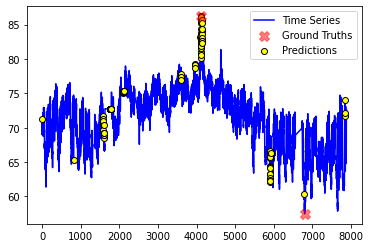

In [7]:
plt.plot(dataset["value"], color="blue", alpha=1, label="Time Series")
plt.scatter(outlier_dataset["timestep"],outlier_dataset["value"], color="red", marker="X", alpha=.5, s=100, zorder=200, label="Ground Truths")
plt.scatter(predictions, predictions_y_values, color="yellow", edgecolor='black', alpha=1, zorder=100, label="Predictions")
plt.legend()
plt.show()

# Concept One

In [8]:
from scipy.special import erf

def make_weights(ts_affected):
    xs = list(np.linspace(0, 3, num=ts_affected))
    ys=[]
    for item in xs:
        ys.append(erf(item))
    return ys

In [9]:
# CONCEPT ONE ONLY

def hitl_anomaly(detections, anomaly_scores, threshold, ts_affected):
    reduced_detections = []
    while detections:
        reduced_detections.append(detections[0])
        weights = make_weights(ts_affected)
        weight_index = 0
        for i in range(detections[0]+1, detections[0] + len(weights)):
            anomaly_scores[i] = anomaly_scores[i] * weights[weight_index]
            weight_index += 1   
        # update detections
        new_detections = []
        for k in range(detections[0] + 1,len(anomaly_scores)):
            if anomaly_scores[k] >= threshold:
                new_detections.append(k)
        detections = new_detections
        if len(anomaly_scores) - detections[0] < ts_affected:
            break
    return reduced_detections

In [10]:
reduced_detections = hitl_anomaly(predictions, anomaly_scores,  0.9998, int(.02 * len(anomaly_scores)))

In [11]:
len(predictions)

119

In [12]:
len(reduced_detections)

10

In [13]:
reduced_detections_y_values = []
for prediction in reduced_detections:
    reduced_detections_y_values.append(dataset["value"].values[prediction])

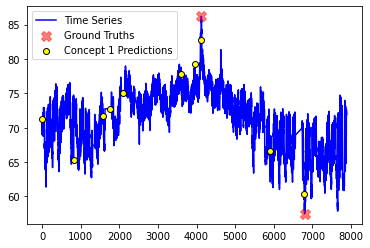

In [14]:
plt.plot(dataset["value"], color="blue", alpha=1, label="Time Series")
plt.scatter(outlier_dataset["timestep"],outlier_dataset["value"], color="red", marker="X", alpha=.5, s=100, zorder=200, label="Ground Truths")
plt.scatter(reduced_detections, reduced_detections_y_values, color="yellow", edgecolor='black', alpha=1, zorder=100, label="Concept 1 Predictions")
plt.legend()
plt.show()

# Concept Two

In [15]:
import math

def disagree_weight(x,k,b):
   return 1 / (1 + math.exp(-k*x+b))

In [16]:
import mass_ts as mts

# CONCEPT TWO ONLY

n_jobs = 4
def hitl_anomaly(ts, detections, anomaly_scores, threshold, ts_affected, top_j, min_weight, acceptance_range, gts="unknown"):
    reduced_detections = []
    while detections:
        reduced_detections.append(detections[0])
        if gts == "unknown":
            print("\n\nLOOKING AT DETECTION AT INDEX: ", detections[0])
            answer = input("Do you agree with this predicted anomaly? y or n: ")
            print("Your Answer: ", answer)
        else:
            answer = "n"
            for gt in gts:
                if abs(detections[0]-gt) < acceptance_range:
                    answer = "y"
                    break
        if answer == "n":
            if detections[0] - ts_affected > 0:
                # create the query for mass by creating a subsequence around this 
                # detection of size ts_affected
                # the detection is in the CENTER of the subsequence
                query = ts[detections[0] - int(ts_affected/2):detections[0] + int(ts_affected/2)]
                if len(query) < ts_affected:
                    query = ts[detections[0] - int(ts_affected/2):detections[0] + int(ts_affected/2) + 1]
                # now use mass
                indices, dists = mts.mass2_batch(ts, query, batch_size=ts_affected,top_matches=top_j,n_jobs=n_jobs)
                # get max distance to use for determining weights
                top_discords = mts.top_k_discords(dists, k=2, exclusion_zone=25)
                a = np.array(ts[top_discords[0]:top_discords[0]+len(query)])
                query_np = np.array(query)
                max_dist = np.linalg.norm(a-query_np)
                b = math.log((1-min_weight)/min_weight)
                k = (math.log(.0001)-b)/-max_dist
                for l in range(len(indices)):
                    starting_index = indices[l]
                    if (starting_index <= detections[0]) and (detections[0] <= starting_index + ts_affected):
                        continue
                    else:
                        subseq_distance = float(dists[l]) 
                        for i in range(starting_index, starting_index + ts_affected):
                            anomaly_scores[i] = anomaly_scores[i] * disagree_weight(subseq_distance, k, b)
            # if the detection is either too early or too late in the timeseries to form a full subsequence
            # skip this step
            else:
                pass
        if answer == "y":
            pass
        # update detections
        new_detections = []
        for k in range(detections[0] + 1,len(anomaly_scores)):
            if anomaly_scores[k] >= threshold:
                new_detections.append(k)
        detections = new_detections
        if not detections:
            break
        if len(anomaly_scores) - detections[0] < ts_affected:
            break
    return reduced_detections

In [17]:
anomaly_scores = joblib.load("data/anomaly_scores")["Anomaly Scores"]

reduced_detections = hitl_anomaly(list(dataset["value"]),predictions, anomaly_scores, threshold, int(.02 * len(anomaly_scores)), 3, .95, 25,[4124,6801])

In [18]:
len(reduced_detections)

52

In [19]:
reduced_detections_y_values = []
for prediction in reduced_detections:
    reduced_detections_y_values.append(dataset["value"].values[prediction])

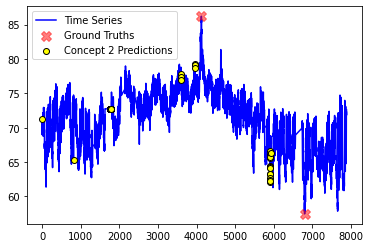

In [20]:
plt.plot(dataset["value"], color="blue", alpha=1, label="Time Series")
plt.scatter(outlier_dataset["timestep"],outlier_dataset["value"], color="red", marker="X", alpha=.5, s=100, zorder=200, label="Ground Truths")
plt.scatter(reduced_detections, reduced_detections_y_values, color="yellow", edgecolor='black', alpha=1, zorder=100, label="Concept 2 Predictions")
plt.legend()
plt.show()

# Concepts 1 and 2

In [21]:
def hitl_anomaly(ts, detections, anomaly_scores, threshold, ts_affected, top_j, min_weight, acceptance_range, gts="unknown"):
    reduced_detections = []
    weights = make_weights(ts_affected)
    while detections:
        reduced_detections.append(detections[0])
        # anomaly score is slightly punished after a detection to avoid false alarms
        weight_index = 0
        for i in range(detections[0]+1, detections[0] + 1 + len(weights)):
            anomaly_scores[i] = anomaly_scores[i] * weights[weight_index]
            weight_index += 1
        # HITL portion
        if gts == "unknown":
            print("\n\nLOOKING AT DETECTION AT INDEX: ", detections[0])
            answer = input("Do you agree with this predicted anomaly? y or n: ")
            print("Your Answer: ", answer)
        else:
            answer = "n"
            for gt in gts:
                if abs(detections[0]-gt) < acceptance_range:
                    answer = "y"
                    break
        if answer == "n":
            if detections[0] - int(ts_affected/2) > 0:
                # create the query for mass by creating a subsequence around this 
                # detection of size ts_affected
                # the detection is in the CENTER of the subsequence
                query = ts[detections[0] - int(ts_affected/2):detections[0] + int(ts_affected/2)]
                if len(query) < ts_affected:
                    query = ts[detections[0] - int(ts_affected/2):detections[0] + int(ts_affected/2) + 1]
                # now use mass
                indices, dists = mts.mass2_batch(ts, query, batch_size=ts_affected,top_matches=top_j,n_jobs=4)
                # get max distance to use for determining weights
                top_discords = mts.top_k_discords(dists, k=2, exclusion_zone=25)
                a = np.array(ts[top_discords[0]:top_discords[0]+len(query)])
                query_np = np.array(query)
                # use 2 norm
                max_dist = np.linalg.norm(a-query_np)
                b = math.log((1-min_weight)/min_weight)
                k = (math.log(.0001)-b)/-max_dist
                for l in range(len(indices)):
                    starting_index = indices[l]
                    if (starting_index <= detections[0]) and (detections[0] <= starting_index + ts_affected):
                        continue
                    else:
                        subseq_distance = float(dists[l])
                        for i in range(starting_index, starting_index + ts_affected):
                            anomaly_scores[i] = anomaly_scores[i] * disagree_weight(subseq_distance, k, b)                   
            # if the detection is either too early or too late in the timeseries to form a full subsequence
            # skip this step
            else:
                pass
        else:
            print("Yes!")
            print(detections[0])
        # update detections
        new_detections = []
        for k in range(detections[0] + 1,len(anomaly_scores)):
            if anomaly_scores[k] >= threshold:
                new_detections.append(k)
        detections = new_detections
        if not detections:
            break
        if len(anomaly_scores) - detections[0] < ts_affected:
            break
    return reduced_detections

In [22]:
anomaly_scores = joblib.load("data/anomaly_scores")["Anomaly Scores"]

reduced_detections = hitl_anomaly(list(dataset["value"]),predictions, anomaly_scores, threshold, int(.02 * len(anomaly_scores)), 3, .95, 25,[4124,6801])

Yes!
4104
Yes!
6788


In [23]:
len(reduced_detections)

8

In [24]:
reduced_detections_y_values = []
for prediction in reduced_detections:
    reduced_detections_y_values.append(dataset["value"].values[prediction])

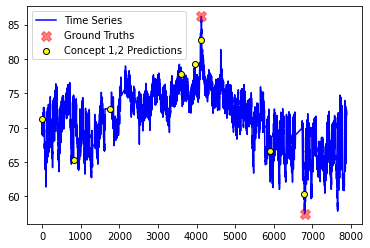

In [25]:
plt.plot(dataset["value"], color="blue", alpha=1, label="Time Series")
plt.scatter(outlier_dataset["timestep"],outlier_dataset["value"], color="red", marker="X", alpha=.5, s=100, zorder=200, label="Ground Truths")
plt.scatter(reduced_detections, reduced_detections_y_values, color="yellow", edgecolor='black', alpha=1, zorder=100, label="Concept 1,2 Predictions")
plt.legend()
plt.show()